# Experiência 3 - Processamento Estatístico de Sinais

In [37]:
using PyPlot, SampledSignals, DSP, Statistics, FixedPointNumbers, PyCall
#@pyimport seaborn as sns
IJulia.installkernel("Julia nodeps", "--depwarn=no");
#sns.set()

┌ Info: Installing Julia nodeps kernelspec in C:\Users\lucas\AppData\Roaming\jupyter\kernels\julia-nodeps-1.4
└ @ IJulia C:\Users\lucas\.julia\packages\IJulia\DrVMH\deps\kspec.jl:78


In [38]:
# • Faixa de passagem: 0 ≤ ω ≤ ωp = 0,05π rad/amostra,
# • Faixa de rejei¸c˜ao: 0,5π rad/amostra = ωr ≤ ω ≤ π rad/amostra,
# • Atenua¸c˜ao m´ınima na faixa de rejei¸c˜ao: 40 dB,
# • Queda m´axima na faixa de passagem δp = 0,05.

ωp = 0.05π
ωr = 0.5π
δr = 0.01
δp = 0.05

0.05

# 1. Construção da função AnalogButter

In [39]:
#definindo a função AnalogButter

function analogButter(δp, δr, Ωp, Ωr)
    # Filtro ButterWorth normalizado
    
    # 1. Normalizando as frequências
    Ωr_n = Ωr/Ωp
    Ωp_n = 1.0
    
    # 2. Calculando Δ1 e Δ2
    Δ1 = sqrt((2*δp - δp^2)/(1 - δp)^2)
    Δ2 = sqrt((1 - δr^2)/(δr^2))
    
    # 3. Calculando N
    N = ceil(Int, log(Δ2/Δ1)/log(Ωr_n))
    
    # 4. Calculando C
    C = 0.5*((Δ1) + (Δ2/(Ωr_n^N)))
    
    # 5. Encontrando os polos e o ganho
    k = collect(Int16,0:1:2N-1)
    expoentes = im*(π/2N .+ π*k/N)
    sk_n = im*(1/C^(1/N))*exp.(expoentes)
    
    # polos com a parte real negativa
    pk_n = sk_n[1:N]
    K_n = 1/C
    
    # 6. Desnormalizando o filtro
    pk = pk_n*Ωp
    K = K_n*Ωp^N
    
    return K, pk
    
end

analogButter (generic function with 1 method)

In [40]:
# gerando agora um filtro digital
function digitalLowPass(δp, δr, ωp, ωr)
    # 1. Cálculo das frequencias analógicas
    Ωrc = tan(ωr/2)
    Ωpc = tan(ωp/2)

    # 2. Obter o filtro analógico equivalente
    (K, pk) = analogButter(δp, δr, Ωpc, Ωrc)
    N = length(pk)
    
    # 3. Transformando de analógico para digital
    pk_d = (1 .+ pk)./(1 .- pk)
    zk_d = -1*ones(N)
    
    # 4. Forçando que o ganho em z = 0 seja 1
    A_d = real(prod(1 .- pk_d)/prod(1 .- zk_d))
    
    return (zk_d, pk_d, A_d)
end

digitalLowPass (generic function with 1 method)

In [41]:
ωp = 0.05π
ωr = 0.5π
δr = 0.01
δp = 0.05


(zk_d, pk_d, A_d) = digitalLowPass(δp, δr, ωp, ωr);

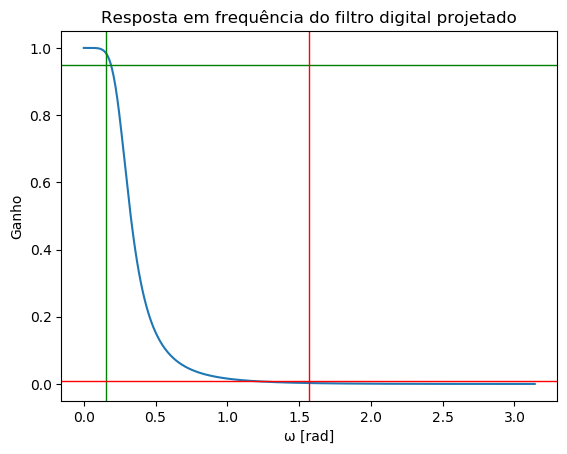

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [42]:
H = ZeroPoleGain(zk_d, pk_d, A_d)
ω = range(0,π,length=500)
H_resp_freq = freqz(H, ω)

plot(ω, abs.(H_resp_freq))
xlabel("ω [rad]")
ylabel("Ganho")
# banda passante
axvline(ωp, color="green", linewidth = 1)
axhline(1-δp, color="green", linewidth = 1)
# banda rejeitada
axvline(ωr, color="red", linewidth = 1) 
axhline(δr, color="red", linewidth = 1)

title("Resposta em frequência do filtro digital projetado")
show()

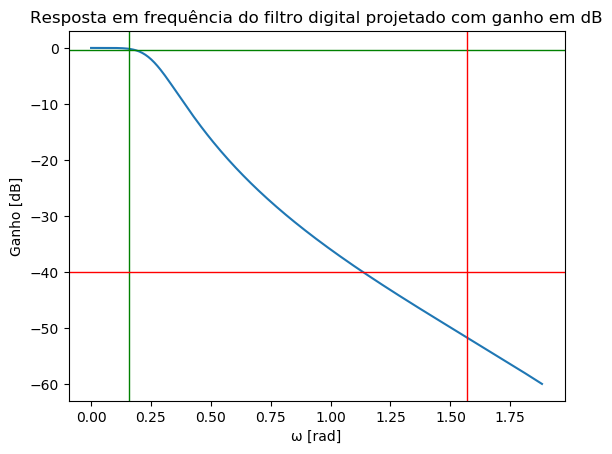

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [43]:
plot(ω[1:300], amp2db.(abs.(H_resp_freq[1:300])))

xlabel("ω [rad]")
ylabel("Ganho [dB]")

# banda passante
axvline(ωp, color="green", linewidth = 1)
axhline(amp2db(1-δp), color="green", linewidth = 1)
# banda rejeitada
axvline(ωr, color="red", linewidth = 1) 
axhline(amp2db(δr), color="red", linewidth = 1)

title("Resposta em frequência do filtro digital projetado com ganho em dB")
show()

## Questao 3

In [44]:
function filter_original(sinal, filtro_zpk)
    # Transformando o filtro zpk em um filtro da forma polinomial
    n = length(sinal)
    filtro_polinomial = PolynomialRatio(filtro_zpk)
    
    # Calculando a resposta em frequência do filtro do mesmo tamanho do sinal recebido
    h_n = impz(filtro_polinomial, n)
    
    # Realizando a convolução entre a resposta ao impulso do filtro e o sinal de entrada
    return conv(h_n, sinal)
end

filter_original (generic function with 1 method)

In [45]:
# Gerando o sinal original s[n] com 1000 pontos

n = collect(Int16,1:1:1000);
σ2 = 0.04
σ = sqrt(σ2) # desvio padrao equivalente a variancia de 0.04
v_n = randn(1000)*σ;

s_n = sin.(π/20*n) .+ v_n;

# Filtrando o sinal
s_f = filter_original(s_n, H);

In [46]:
s_n = sin.(π/20*n) .+ v_n;

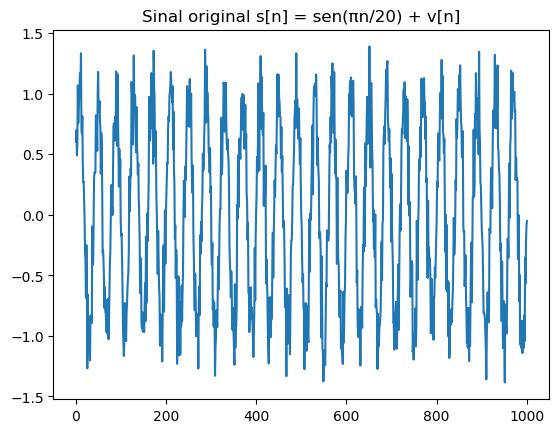

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [47]:
plot(n, s_n)
title("Sinal original s[n] = sen(πn/20) + v[n]")
show();

In [48]:
s_f = filter_original(s_n, H);

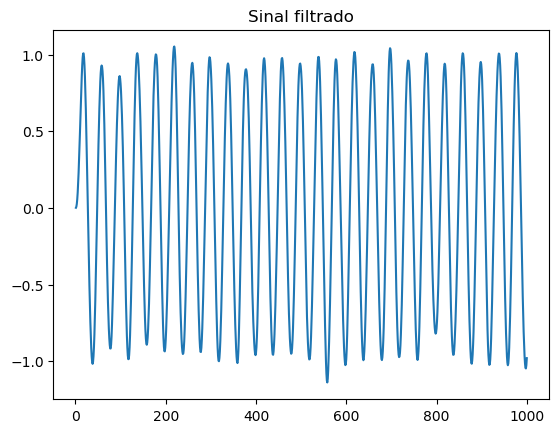

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [49]:
plot(n, s_f[1:length(n)])
title("Sinal filtrado")
show();

# 4. Projeto do Filtro de Butterworth usando funções

Nessa etapa, faremos o projeto do filtro de Butterworth utilizando as funções da biblioteca SciPy.
Abaixo, tem-se a descrição do procedimento: 

- Calcular o número de coeficientes $N$ e a frequência de corte $W_{n}$ usando o algoritmo buttowrd. 
- O algoritmo butter calcula os zeros, polos e ganho do filtro IIR.
- Então, utiliza-se a função ZeroPoleGain para constituir a função de transferência.
- Por fim, filtra-se o sinal utilizando o método filt().

In [50]:
sig = pyimport_conda("scipy.signal", "scipy");

In [51]:
ωp = 0.05*π
δp = 0.05
ωr = 0.5*π
δr = 0.01;

In [52]:
N,Wn = sig.buttord(ωp/π, ωr/π, -20*log10(1-δp), -20*log10(δr));

In [53]:
z,p,k = sig.butter(N, Wn, btype="lowpass", output="zpk");

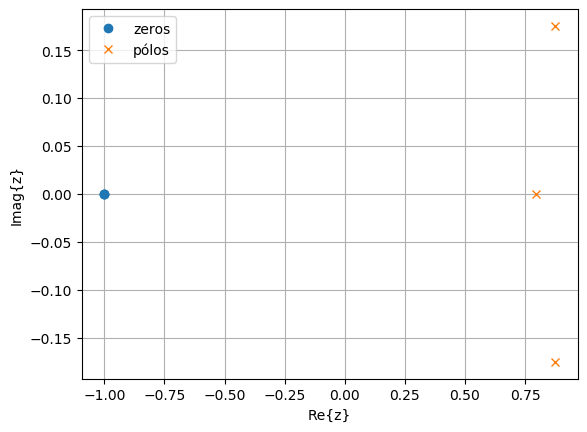

ganho= 0.0011812219324066375

In [54]:
print("ganho= ",k)
plot(real.(z),imag.(z),"o",label="zeros")
plot(real.(p),imag.(p),"x",label="pólos")
grid()
xlabel("Re{z}")
ylabel("Imag{z}")
legend();

In [55]:
H = ZeroPoleGain(z, p, k);

In [56]:
n = collect(Int16,1:1:1000);
v_n= randn(1000)
s_n= sin.(π/20*n) .+ v_n;

In [57]:
sf = filt(H, s_n);

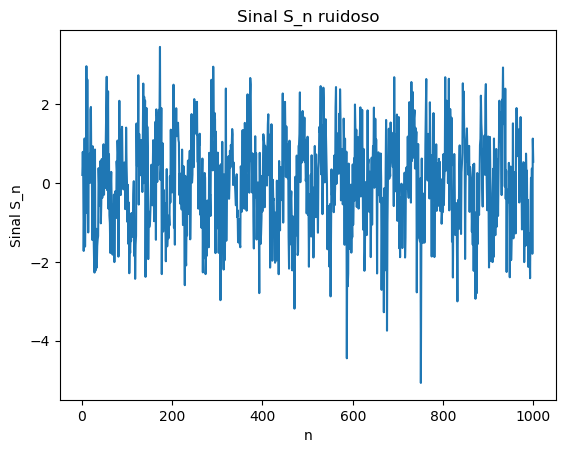

In [58]:
plot(n, s_n)
title("Sinal S_n ruidoso");
ylabel("Sinal S_n");
xlabel("n");

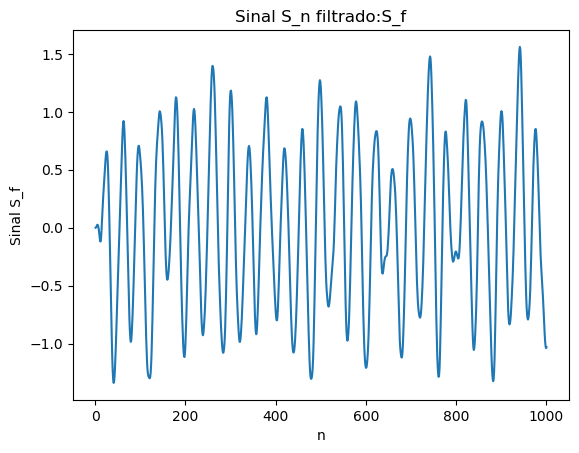

In [59]:
plot(n, sf)
title("Sinal S_n filtrado:S_f");
ylabel("Sinal S_f");
xlabel("n");

## Exercício 5 - Filtro MinMax

### Desenvolvendo a teoria do Filtro MinMax

Dado o filtro desejado $H_{d}(e^{j\omega})$: o objetivo é minimizar o máximo módulo da diferença entre o filtro obtido $H(e^{j\omega})$ e o filtro desejado, conforme abaixo:

$$min\space max \space  W(\omega) \space |H(e^{j\omega}) - H_{d}(e^{j\omega})|, \forall h[0],...,h[N-1] \space,  \omega \in F$$

Em que:

$$ F = [0, \omega_{p}] \space \cup \space [\omega_{r}, \pi] $$

$F$ é o conjunto de frequências importantes, onde o ganho do filtro precisa ser controlado.

Além disso, tem-se os parâmetros $\delta_{p}$ e $\delta_{r}$, que controlam a distorção máxima de ganho nas regiões de interesse do filtro, na região de passagem **p** e "recusagem" **r**.

Note que há um parâmetro denominado $W(\omega)$ na expressão. Esse parâmetro é é o peso para controlar a minimização de acordo com as diferentes condições de $\delta$, de forma que um limite de distorção mais significativo que o outro não influencie muito mais que o outro na expressão.

(Ver relatório)

Para escolher o cumprimento do filtro, basta utilizar a seguinte aproximação:

$$N = \frac{-10log(\delta_{p} \delta_{r}) - 13}{2.324 \Delta \omega} + 1$$

Abaixo, tem-se a implementação do software de projeto do filtro na linguagem Julia:

In [60]:
ω = range(0,π,length=1000)
ωp = 0.05*π
ωr = 0.5*π
Δω = ωr - ωp
δp = 0.05
δr = 0.01;
A=-20*log10(min(δp, δr));
ωc = (ωp+ωr)/2;

In [61]:
N = ceil(Int,(-10*log10(δp*δr)-13)/(2.324*Δω))+1

8

In [62]:
h = remez(N, [(0, ωp/2π) => (1, 1), (ωr/2π, 0.5) => (0, δp/δr)]);
M = N-1
L = M/2

3.5

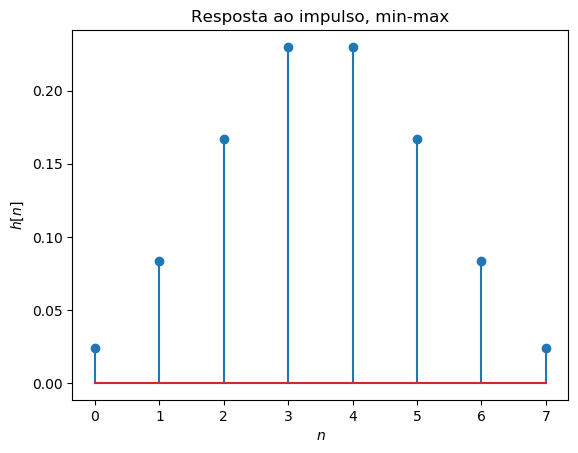

sys:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


In [63]:
n=0:M;
stem(n,h);
xlabel(L"$n$");
title("Resposta ao impulso, min-max");
ylabel(L"$h[n]$");

In [64]:
hf = PolynomialRatio(h,[1]);
H = freqz(hf,ω);

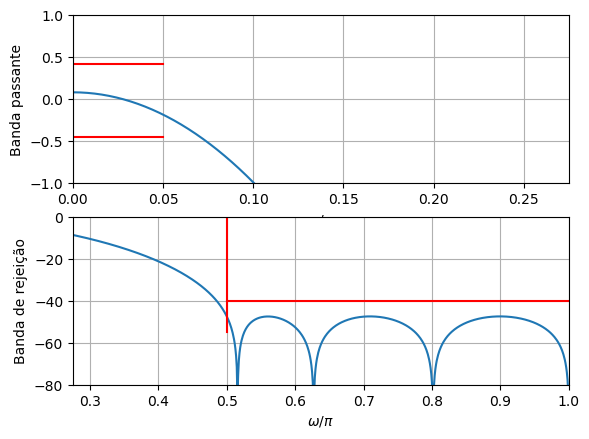

In [65]:
subplot(211)
plot(ω/π,20*log10.(abs.(H)))
plot([0;ωp/π],20*log10.([1-δp;1-δp]),"r")
plot([0;ωp/π],20*log10.([1+δp;1+δp]),"r")
#plot([ωp;ωp]/π,[-65;5])
axis([0,ωc/π,-1.0,1.0])
grid()
ylabel(L"$|H(e^{j\omega})|$")
xlabel(L"$\omega/\pi$");
ylabel("Banda passante")


subplot(212)
plot(ω/π,20*log10.(abs.(H)))
plot([ωr;π]/π,20*log10.([δr;δr]),"r")
plot([ωr;ωr]/π,[-A-15,5],"r")
axis([ωc/π,1,-A-40,-A+40])
ylabel("Banda de rejeição")
#plot(ω/π,angle.(H)*180/π)
grid()
xlabel(L"$\omega/\pi$");